In [1]:
# import functions from ../definitions/definitions_EDA
from datetime import timedelta
import sys
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
sys.path.append('../definitions')
import definitions_EDA as eda
# import definitions_plotting as def_plot
from scipy.fft import fft, ifft, fftfreq
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import shutil
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from pandas.plotting import autocorrelation_plot
from scipy.signal import find_peaks


Define Variables

In [2]:
start_date = '2024-04-23'
end_date = '2024-04-23'

Fetch data and store as dataframe (data ingestion)

In [3]:
data_arr_mag = eda.process_data(eda.get_data('ctumag', eda.read_txt_file, start_date, end_date))
data_arr_squid = eda.process_data(eda.get_data('squid', eda.read_txt_file, start_date, end_date))
df = eda.create_dataframe(data_arr_mag, data_arr_squid, start_date)
df = df.between_time('11:00:00', '14:00:00')
# print(f' \n Shape of df', df.shape)
print(f' \nNumber of days data = \n Total records {df.shape[0]} / records per day (431998) = {df.shape[0]/431998}')
print(f' \nHead of dataframe: \n',df.head())

The total number of duplicates is: 0
 
Number of days data = 
 Total records 57599 / records per day (431998) = 0.13333163579461016
 
Head of dataframe: 
                          NS_SQUID  F_SQUID  NS_Fluxgate  EW_Fluxgate  \
Time                                                                   
2024-04-23 11:06:40.030  128.0233  11.6265   10939.8573     -79.4288   
2024-04-23 11:06:40.230  128.0217  11.6286   10939.8593     -79.4247   
2024-04-23 11:06:40.430  128.0180  11.6294   10939.8593     -79.4247   
2024-04-23 11:06:40.630  128.0168  11.6360   10939.8527     -79.4019   
2024-04-23 11:06:40.830  128.0152  11.6265   10939.8527     -79.4019   

                         Z_Fluxgate  
Time                                 
2024-04-23 11:06:40.030 -22665.0912  
2024-04-23 11:06:40.230 -22665.0827  
2024-04-23 11:06:40.430 -22665.0827  
2024-04-23 11:06:40.630 -22665.0357  
2024-04-23 11:06:40.830 -22665.0357  


Plot the raw data

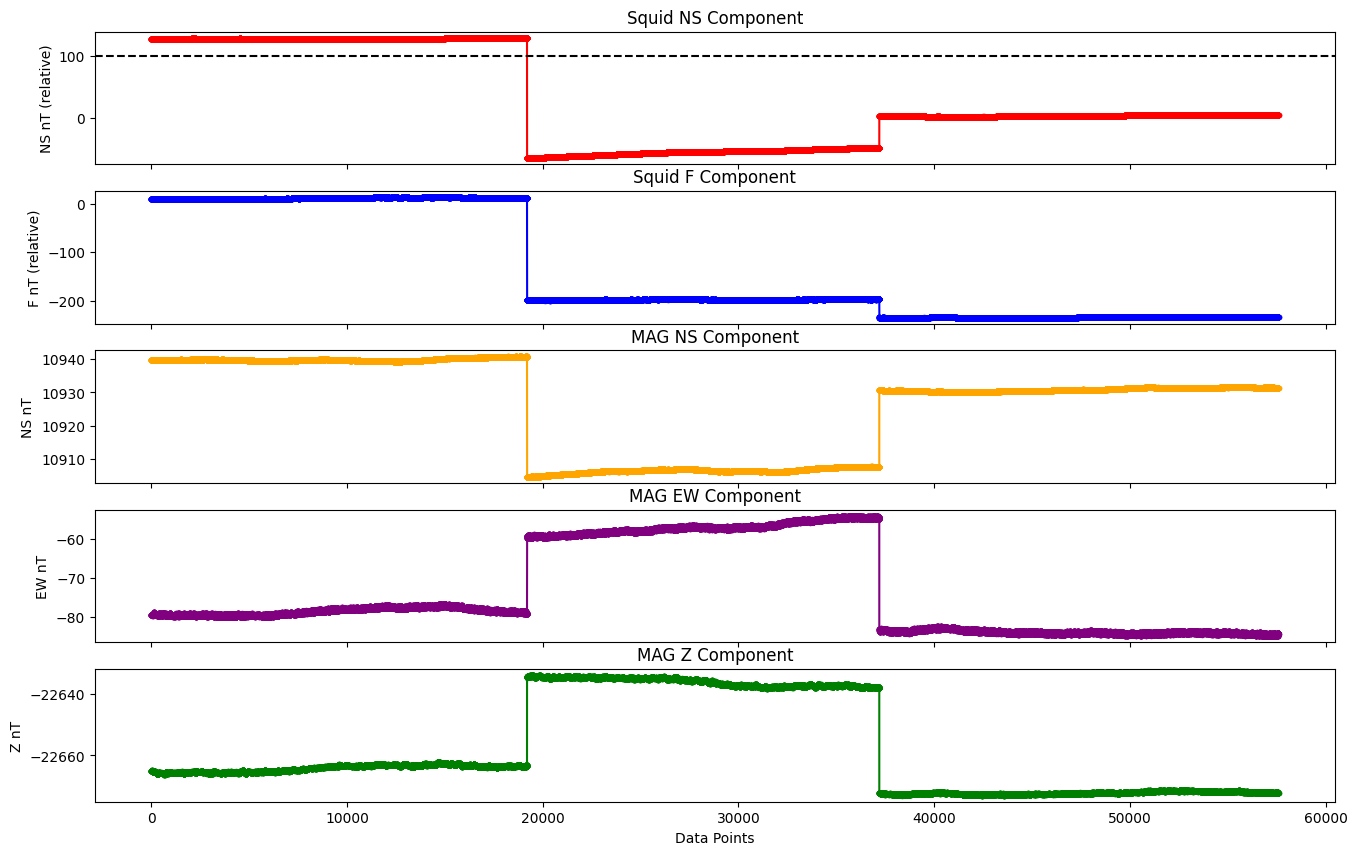

In [4]:
eda.generateDataPlots(df['NS_SQUID'].values, df['F_SQUID'].values, df['NS_Fluxgate'].values, df['EW_Fluxgate'].values, df['Z_Fluxgate'].values, df.shape[0], 431997, start_date, end_date)


As we can see there are severe drops in the squid data. Lets fix these

Fix sudden drops or jumps in SQUID data

DatetimeIndex(['2024-04-24 12:06:40.190000', '2024-04-25 11:00:00.140000'], dtype='datetime64[ns]', name='Time', freq=None)
Spikes detected at indices: DatetimeIndex(['2024-04-24 12:06:40.190000', '2024-04-25 11:00:00.140000'], dtype='datetime64[ns]', name='Time', freq=None)
2
DatetimeIndex(['2024-04-24 12:06:40.190000', '2024-04-25 11:00:00.140000'], dtype='datetime64[ns]', name='Time', freq=None)
Spikes detected at indices: DatetimeIndex(['2024-04-24 12:06:40.190000', '2024-04-25 11:00:00.140000'], dtype='datetime64[ns]', name='Time', freq=None)
2
DatetimeIndex(['2024-04-24 12:06:40.190000', '2024-04-25 11:00:00.140000'], dtype='datetime64[ns]', name='Time', freq=None)
Spikes detected at indices: DatetimeIndex(['2024-04-24 12:06:40.190000', '2024-04-25 11:00:00.140000'], dtype='datetime64[ns]', name='Time', freq=None)
2
DatetimeIndex(['2024-04-24 12:06:40.190000', '2024-04-25 11:00:00.140000'], dtype='datetime64[ns]', name='Time', freq=None)
Spikes detected at indices: DatetimeIndex(

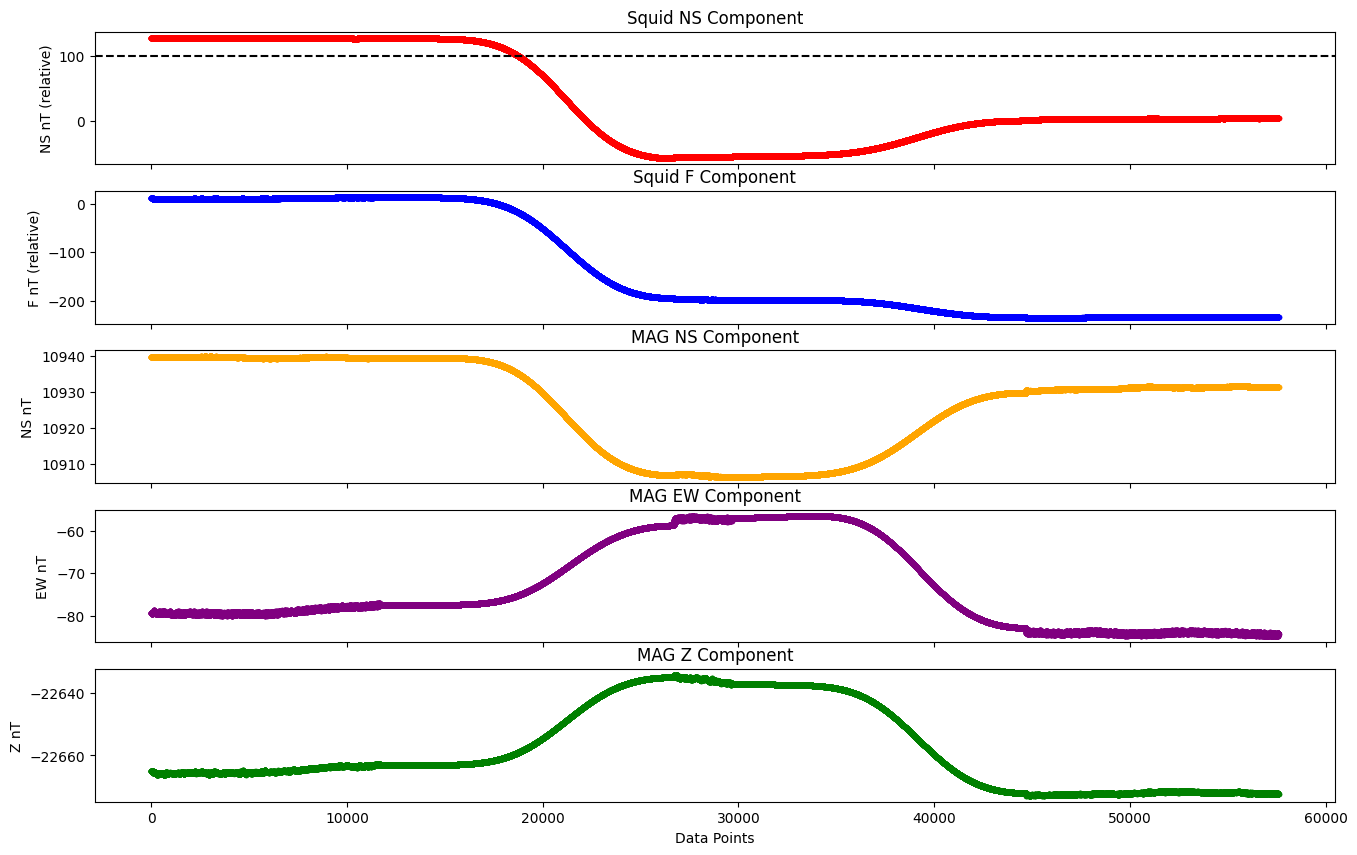

In [5]:
def detect_spikes_and_correct(df, column_name, threshold=15):
    """
    Detects spikes in the data and smooths them by adjusting the spike value.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - column_name (str): The name of the column to check for spikes.
    - threshold (float): The threshold for detecting spikes in terms of standard deviations.

    Returns:
    - corrected_df (pd.DataFrame): The DataFrame with the spikes corrected.
    """

    # Ensure the DataFrame index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DatetimeIndex.")
    
    # Calculate the difference between consecutive values
    diff = df[column_name].diff()

    # Detect spikes by finding where the difference exceeds the threshold
    # std_dev = diff.std()
    spikes = diff.abs() > threshold # * std_dev
    # print(spikes)
    # Get the indices where spikes occur
    spike_indices = spikes[spikes].index
    print(spike_indices)
    if len(spike_indices) == 0:
        print("No spikes detected.")
        return df

    print(f"Spikes detected at indices: {spike_indices}")
    print(len(spike_indices))
    corrected_df = df.copy()

    for index in spike_indices:
        # Find the positions before and after the spike
        prev_index = corrected_df.index.get_loc(index) - 7500
        next_index = corrected_df.index.get_loc(index) + 7500
 
        # my_window = next_index - prev_index
        my_window = 4000


        smoothed_values = corrected_df.iloc[prev_index:next_index + 1, corrected_df.columns.get_loc(column_name)].rolling(window=my_window, min_periods=1).mean()
        smoothed_values = gaussian_filter1d(smoothed_values, sigma=2000)
        corrected_df.iloc[prev_index:next_index + 1, corrected_df.columns.get_loc(column_name)] = smoothed_values
        # Apply moving average only between prev_index and next_index
        # corrected_df.iloc[prev_index:next_index, corrected_df.columns.get_loc(column_name)] = corrected_df.iloc[prev_index:next_index, corrected_df.columns.get_loc(column_name)].rolling(window=my_window).mean()

    return corrected_df

corrected_df_ns = detect_spikes_and_correct(df, "NS_SQUID")
corrected_df_f = detect_spikes_and_correct(corrected_df_ns, "F_SQUID")
corrected_df_nf = detect_spikes_and_correct(corrected_df_f, "NS_Fluxgate")
corrected_df_ew = detect_spikes_and_correct(corrected_df_nf, "EW_Fluxgate")
corrected_df = detect_spikes_and_correct(corrected_df_ew, "Z_Fluxgate")



eda.generateDataPlots(corrected_df['NS_SQUID'].values, corrected_df['F_SQUID'].values, corrected_df['NS_Fluxgate'].values, corrected_df['EW_Fluxgate'].values, corrected_df['Z_Fluxgate'].values, corrected_df.shape[0], 431997, start_date, end_date)
# corrected_df_f = detect_spikes_and_correct(corrected_df_ns, "F_SQUID")

Plot to check

Check for missing values and zero values

In [ ]:
for column in df.columns:
    print(f"\n Number of missing values in {column} is: ", df[column].isna().sum())
    print(f"Nmber of zeros in {column} is: ", (df[column] == 0).sum())


### Choose on of the following 2 outlier tests

[Fix] Z score test

In [ ]:
# print(f' \n Shape of df before removing outliers', df.shape)
# outliers_removed_z = eda.z_score_test(df)
# print(f' \n Shape of df after removing outliers', outliers_removed_z.shape)

Interquatile range check

In [ ]:
print(f' \n Shape of df before removing outliers', df.shape)
outliers_removed_iqr = eda.remove_outliers(df)
print(f' \n Shape of df after removing outliers', outliers_removed_iqr.shape)
print(f"Percentage of removed outliers: {((df.shape[0] - outliers_removed_iqr.shape[0])/df.shape[0])*100 }%")
print(outliers_removed_iqr.head(20))

In [ ]:
for column in outliers_removed_iqr.columns:
    time_indices_with_zeros = outliers_removed_iqr[outliers_removed_iqr[column] == 0].index
    print(f"Time indices with zeros in {column}:")
    print(time_indices_with_zeros)
    print()

Now choose a dataframe to continue calculation with

In [ ]:
# out_removed_df = outliers_removed_z
out_removed_df = outliers_removed_iqr
print(out_removed_df.resample('s').count().head(20))

Plot after outlier removed

In [ ]:
eda.plot_cleaned_data(out_removed_df)

Resample data

In [ ]:
out_removed_df = df
print(f' \n Shape of df', out_removed_df.shape)
resampled_df = eda.resample_data(out_removed_df, 's')
print(f"\n Shape of new resampled dataframe is:", resampled_df.shape)
print(f"\n The number of records we should have is: {round(out_removed_df.shape[0]/5)}")
print(resampled_df.resample('s').count().head(20))


In [ ]:
eda.plot_cleaned_data(resampled_df)

Test for stationarity

In [ ]:
eda.perform_dickey_fuller_test(df)

Now perform differencing on data to ensure stationarity

In [ ]:
df_differenced = resampled_df.diff().dropna()
# print(f"This is the difference dataframe:\n",df_differenced)
eda.perform_dickey_fuller_test(resampled_df)

Test for seasonality and trend

In [ ]:
df = resampled_df
eda.test_stationarity(df)


Now using the autocorrelation_plot

In [ ]:
# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df['EW_Fluxgate'].tolist())

Fourier Transform

In [ ]:
components, fourier_results = eda.calculate_fourier_transforms(df)
eda.plot_fourier_transform(fourier_results, components)

Write the preprocessed dataframe to a file

In [ ]:
df.to_csv('/Users/tristan/Library/CloudStorage/OneDrive-StellenboschUniversity/Academics/Final_year/Semester 2/Skripsie/Data/RESAMPLED/df.csv', index=True)

Create a pdf for each of the columns in the df

In [ ]:
import seaborn as sns

for column in df.columns:
    sns.displot(df[column], kde=True)

Decompose time series into its components

In [ ]:
# Additive Decomposition
# result_add = seasonal_decompose(df['Z_Fluxgate'], model='additive', extrapolate_trend='freq')

# Plot
# plt.rcParams.update({'figure.figsize': (10,10)})
# result_add.plot().suptitle('Additive Decompose', fontsize=22)
# plt.show()